In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances

In [2]:
data = load_wine()
X = data.data  # Features
y = data.target  # Target labels

In [3]:
# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


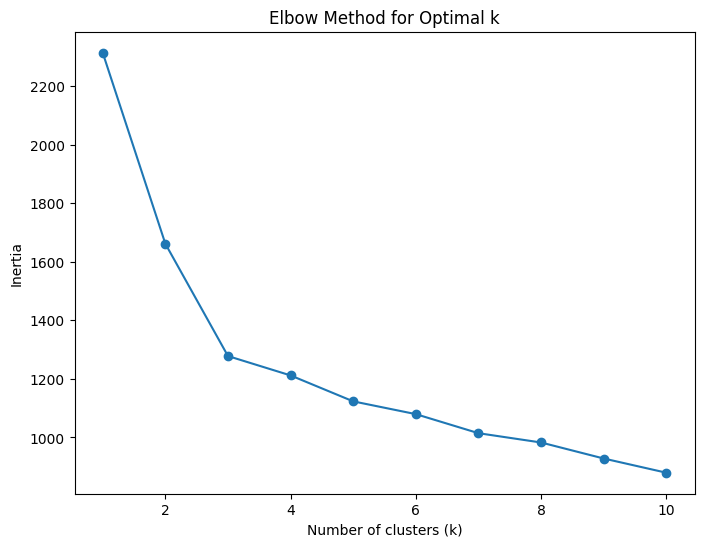

In [4]:
# Compute KMeans inertia for a range of k values
inertias = []
k_values = range(1, 11)  # We try k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plotting inertia vs k
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [5]:
# Chosen k from the elbow plot, say k = 3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Silhouette score
silhouette_avg = silhouette_score(X_scaled, kmeans_labels)
print(f"Silhouette Score for K-Means (k={k}): {silhouette_avg}")


Silhouette Score for K-Means (k=3): 0.2848589191898987


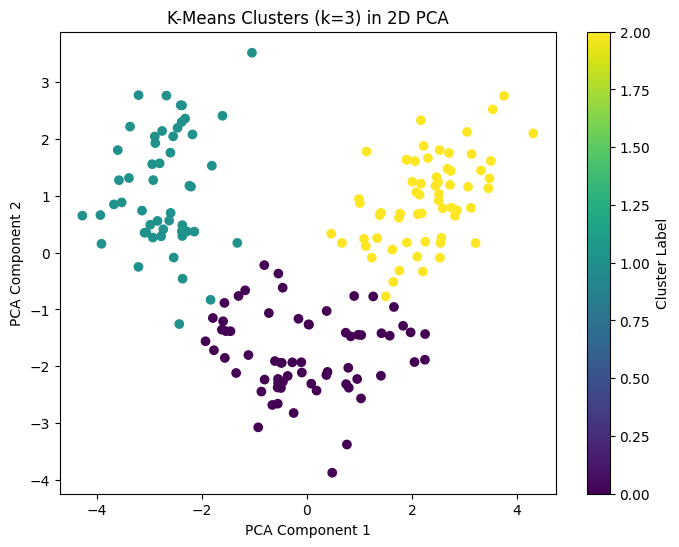

In [6]:
# Reduce the data to 2D using PCA
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_scaled)

# Plotting the clusters in 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title(f'K-Means Clusters (k={k}) in 2D PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [7]:
# Run KMeans with different k values and random seeds
base_labels = []
k_values = [2, 3, 4, 5]  # Different k values
random_seeds = [42, 0, 100]  # Different seeds

for k in k_values:
    for seed in random_seeds:
        kmeans = KMeans(n_clusters=k, random_state=seed)
        labels = kmeans.fit_predict(X_scaled)
        base_labels.append(labels)

# Convert list of base labels to a numpy array for easier manipulation
base_labels = np.array(base_labels)


In [8]:
# Build co-association matrix
n_samples = X_scaled.shape[0]
co_assoc_matrix = np.zeros((n_samples, n_samples))

# For each pair of samples, calculate how often they are in the same cluster
for labels in base_labels:
    for i in range(n_samples):
        for j in range(i+1, n_samples):  # Only upper triangle to avoid repetition
            if labels[i] == labels[j]:
                co_assoc_matrix[i, j] += 1
                co_assoc_matrix[j, i] += 1

# Normalize the matrix by the number of base clusterings
co_assoc_matrix /= len(base_labels)


In [9]:
# Apply Spectral Clustering
spectral = SpectralClustering(affinity='precomputed', n_clusters=k, random_state=42)
spectral_labels = spectral.fit_predict(co_assoc_matrix)

# Silhouette score for Spectral Clustering
silhouette_avg_spectral = silhouette_score(X_scaled, spectral_labels)
print(f"Silhouette Score for Spectral Clustering: {silhouette_avg_spectral}")


Silhouette Score for Spectral Clustering: 0.17427345592854826


KMeans Silhouette Score: 0.2848589191898987
Spectral Clustering Silhouette Score: 0.17427345592854826


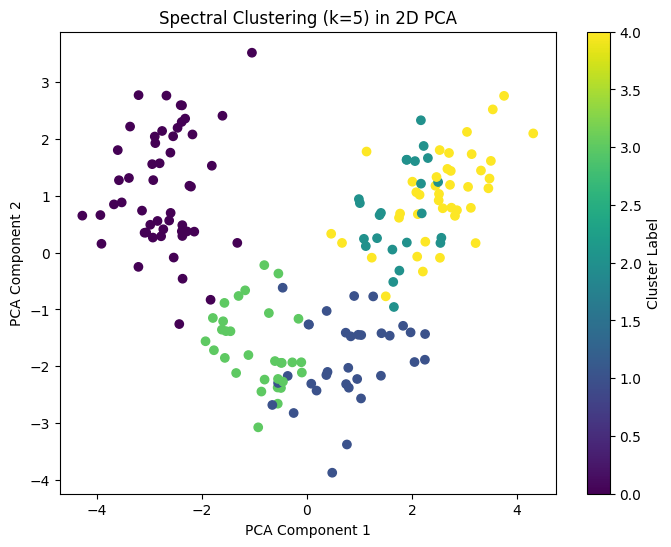

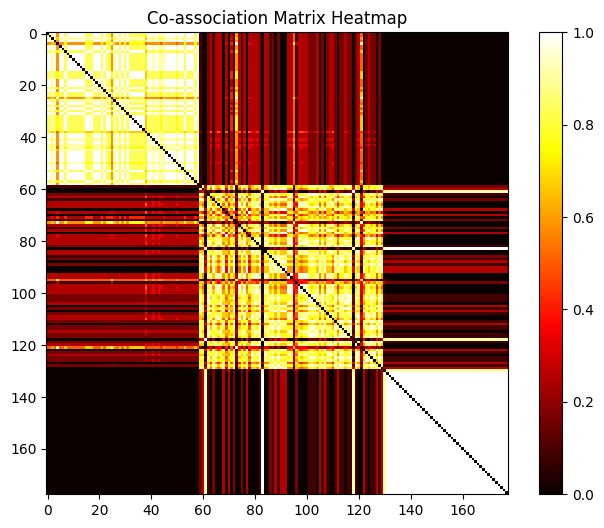

In [10]:
# Compare the silhouette scores
print(f"KMeans Silhouette Score: {silhouette_avg}")
print(f"Spectral Clustering Silhouette Score: {silhouette_avg_spectral}")

# Visualize the Spectral Clustering results on the same PCA projection
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=spectral_labels, cmap='viridis', marker='o')
plt.title(f'Spectral Clustering (k={k}) in 2D PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Optionally, show co-association heatmap
plt.figure(figsize=(8, 6))
plt.imshow(co_assoc_matrix, cmap='hot', interpolation='nearest')
plt.title("Co-association Matrix Heatmap")
plt.colorbar()
plt.show()
